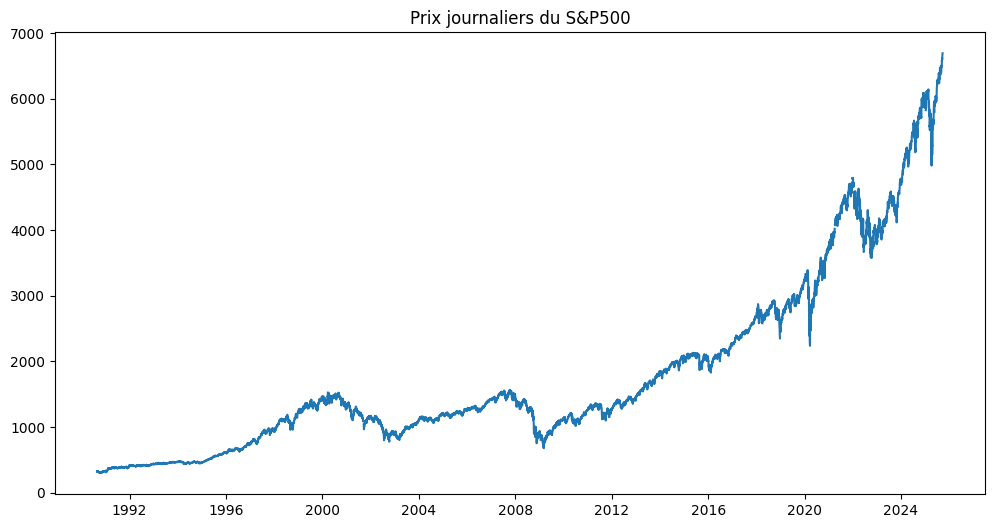

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

# Charger vos données journalières
data = pd.read_excel('sp.xlsx', parse_dates=['date'], index_col='date')
ts = data['close']  # votre série temporelle journalière

# Visualisation rapide
plt.figure(figsize=(12, 6))
plt.plot(ts)
plt.title('Prix journaliers du S&P500')
plt.show()



=== FORECASTING S&P 500 AVEC SARIMA ===

Données chargées: 1305 observations
Période: 2020-01-01 00:00:00 à 2024-12-31 00:00:00
=== CONFIGURATION OPTIMALE POUR S&P 500 ===
Modèle recommandé: SARIMA avec saisonnalité hebdomadaire
Rationale:
- Effet 'day-of-the-week' documenté
- Patterns de fin/début de mois
- Volatility clustering
- Trends à long terme sans stationnarisation forcée
--------------------------------------------------
Test: SARIMA Hebdomadaire (5j)
   Capture les effets day-of-week sur 5 jours ouvrés
   AIC: 4252.40
Test: SARIMA Hebdomadaire (7j)
   Patterns hebdomadaires incluant weekends
   AIC: 4248.96
Test: SARIMA Mensuel
   Effets de fin/début de mois
   AIC: 4210.48
Test: ARIMA Complexe
   ARIMA sans saisonnalité pour comparaison
   Erreur: ARIMA.fit() got an unexpected keyword argument 'di...
Test: SARIMA Double Seasonal
   Focus sur les jours ouvrés
   AIC: 4252.40

=== RÉSULTAT ===
Meilleur modèle: SARIMA Mensuel
Configuration: (2, 1, 2) x (1, 0, 1, 22)
AIC: 4210.

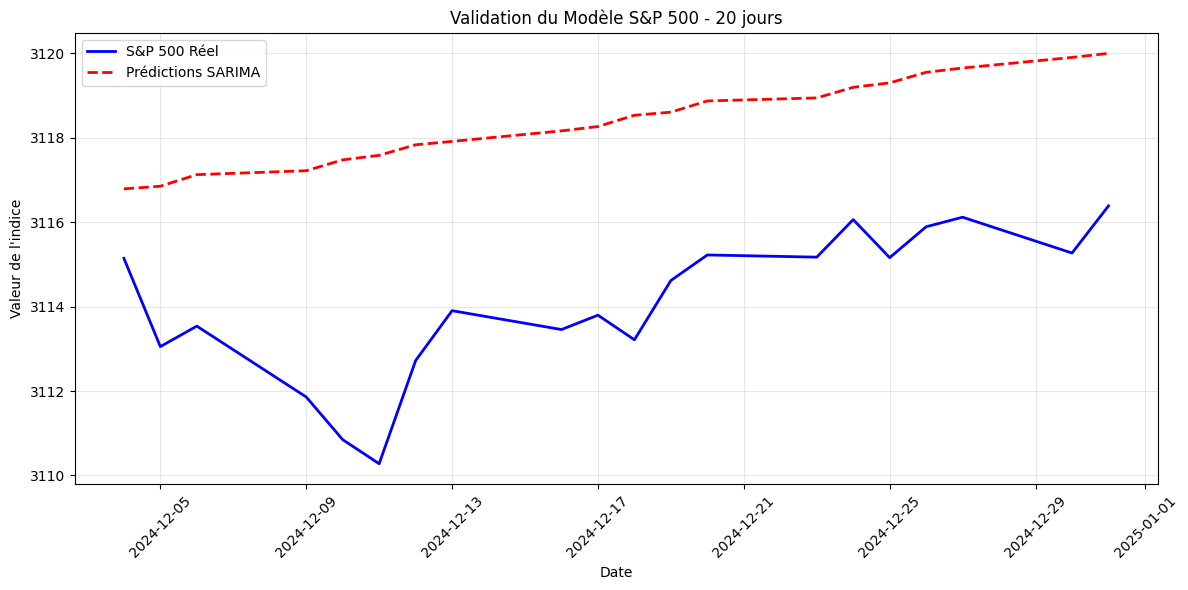


=== PRÉVISIONS FINALES ===


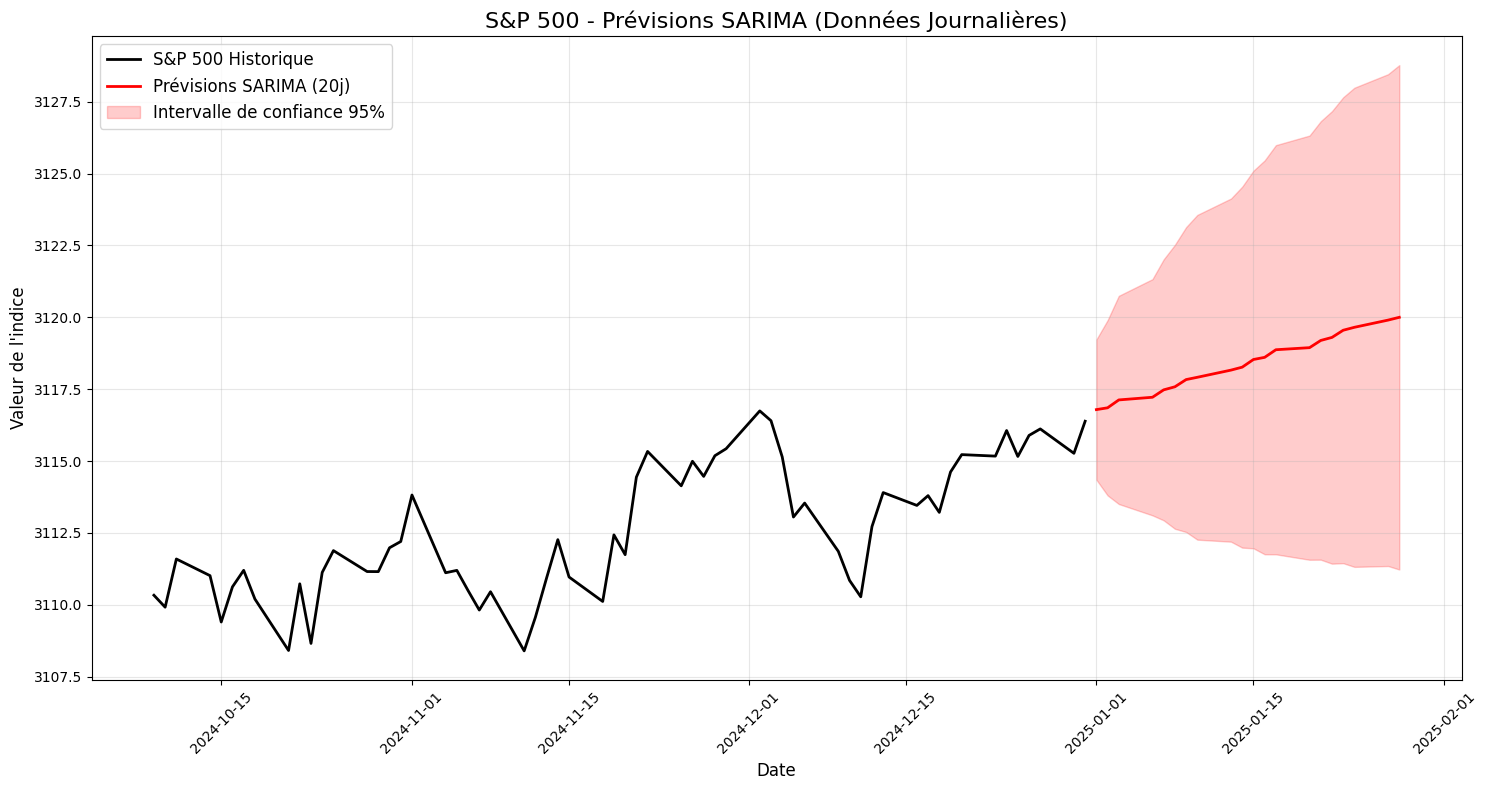


Prévisions pour les 5 prochains jours ouvrés:
2025-01-01: 3116.79
2025-01-02: 3116.85
2025-01-03: 3117.13
2025-01-06: 3117.22
2025-01-07: 3117.48

Dernière valeur: 3116.38
Prévision J+1: 3116.79 (+0.40)


In [ ]:
class SP500SARIMAXForecaster:
    """
    Modèle SARIMAX pour S&P 500 avec variables exogènes
    """
    
    def __init__(self):
        self.model = None
        self.fitted_model = None
        self.data = None
        self.exog_vars = None
        self.feature_names = []
        self.is_fitted = False
        
    def load_data(self, file_path):
        """
        Charge les données depuis le fichier Excel
        """
        try:
            # Lire le fichier Excel
            df = pd.read_excel(file_path)
            
            # Détecter la colonne de date
            date_cols = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
            if date_cols:
                df[date_cols[0]] = pd.to_datetime(df[date_cols[0]])
                df.set_index(date_cols[0], inplace=True)
            else:
                print("Aucune colonne de date détectée. Veuillez spécifier manuellement.")
                
            self.data = df
            return df
            
        except Exception as e:
            print(f"Erreur lors du chargement: {e}")
            return None
    
    def create_market_features(self, target_column='close'):
        """
        Crée des variables techniques et calendaires utiles pour le S&P 500
        
        Parameters:
        -----------
        target_column : str
            Nom de la colonne contenant les prix du S&P 500
        """
        if self.data is None:
            raise ValueError("Données non chargées. Utilisez load_data() d'abord.")
            
        df = self.data.copy()
        
        # === VARIABLES TECHNIQUES ===
        
        # 1. Rendements et volatilité
        if target_column in df.columns:
            df['returns'] = df[target_column].pct_change()
            df['log_returns'] = np.log(df[target_column] / df[target_column].shift(1))
            
            # Volatilité réalisée (rolling)
            df['volatility_5d'] = df['returns'].rolling(5).std()
            df['volatility_20d'] = df['returns'].rolling(20).std()
        
        # 2. Moyennes mobiles et signaux techniques
        if target_column in df.columns:
            df['MOV_AVG_10D'] = df['MOV_AVG_10D']
            df['MOV_AVG_30D'] = df['MOV_AVG_30D']
            df['MOV_AVG_50D'] = df['MOV_AVG_50D']
            
            # Signaux techniques
            df['ma_signal_short'] = (df[target_column] > df['MOV_AVG_10D']).astype(int)
            df['ma_signal_long'] = (df[target_column] > df['MOV_AVG_50D']).astype(int)
            
            # RSI approximatif
            df['RSI_3D'] = df['RSI_3D']
            df['RSI_9D'] = df['RSI_9D']
            df['RSI_14D'] = df['RSI_14D']
            df['RSI_30D'] = df['RSI_30D']
        
        # 3. Volume (si disponible)
        if 'volume' in df.columns:
            df['volume_ma_20'] = df['volume'].rolling(20).mean()
            df['volume_ratio'] = df['volume'] / df['volume_ma_20']
            df['high_volume'] = (df['volume_ratio'] > 1.5).astype(int)
        
        # === VARIABLES MACRO-ÉCONOMIQUES (si disponibles) ===
        
        # VIX (si disponible)
        if 'vix' in df.columns:
            df['vix_high'] = (df['vix'] > 25).astype(int)
            df['vix_very_high'] = (df['vix'] > 35).astype(int)
        
        # Taux d'intérêt (si disponible)
        if any('i' in col.lower() for col in df.columns):
            rate_cols = [col for col in df.columns if 'i' in col.lower()]
            for col in rate_cols:
                df[f'{col}_change'] = df[col].diff()
        
        # Taux d'intérêt anticipé
        df['i_future_change'] = df['i_future'].diff()
            
        # Dollar Index (si disponible)
        if 'DXY' in df.columns or 'USD' in df.columns:
            usd_col = 'DXY' if 'DXY' in df.columns else [col for col in df.columns if 'USD' in col][0]
            df['usd_strong'] = (df[usd_col] > df[usd_col].rolling(50).mean()).astype(int)
        
        # === VARIABLES DE SENTIMENT ===
        
        # Patterns de prix
        #if all(col in df.columns for col in ['Open', 'High', 'Low', 'close']):
        #    # Gap up/down
        #    df['gap_up'] = (df['Open'] > df['close'].shift(1) * 1.005).astype(int)
        #    df['gap_down'] = (df['Open'] < df['close'].shift(1) * 0.995).astype(int)
            
            # Range élevé
        #    df['high_range'] = ((df['High'] - df['Low']) / df['close'] > 0.02).astype(int)
        
        self.data = df
        print(f"Variables créées. Nouvelles dimensions: {df.shape}")
        return df
    
    def select_exog_variables(self, target_column='close', method='correlation'):
        """
        Sélectionne les meilleures variables exogènes
        
        Parameters:
        -----------
        target_column : str
            Variable cible (S&P 500)
        method : str
            'correlation', 'all', ou liste des noms de variables
        """
        if self.data is None:
            raise ValueError("Données non disponibles.")
            
        # Variables candidates (exclure la cible et variables avec trop de NaN)
        exclude_cols = [target_column, 'returns', 'log_returns'] + \
                      [col for col in self.data.columns if self.data[col].isna().sum() > len(self.data) * 0.1]
        
        candidate_vars = [col for col in self.data.columns if col not in exclude_cols and 
                         self.data[col].dtype in ['int64', 'float64', 'bool']]
        
        if method == 'all':
            selected_vars = candidate_vars
        elif method == 'correlation':
            # Sélection basée sur la corrélation avec les rendements
            if 'returns' in self.data.columns:
                correlations = self.data[candidate_vars + ['returns']].corr()['returns'].abs().sort_values(ascending=False)
                # Prendre les 15 variables les plus corrélées
                selected_vars = correlations.head(16).index.tolist()
                selected_vars.remove('returns') if 'returns' in selected_vars else None
            else:
                selected_vars = candidate_vars[:15]  # Limiter à 15 variables
        elif isinstance(method, list):
            selected_vars = [var for var in method if var in candidate_vars]
        else:
            selected_vars = candidate_vars[:10]
        
        # Préparer les données exogènes
        exog_data = self.data[selected_vars].fillna(method='ffill').fillna(0)
        self.exog_vars = exog_data
        self.feature_names = selected_vars
        
        print(f"Variables exogènes sélectionnées ({len(selected_vars)}):")
        for i, var in enumerate(selected_vars, 1):
            print(f"{i:2d}. {var}")
            
        # Montrer les corrélations si disponibles
        if 'returns' in self.data.columns:
            print(f"\nCorrélations avec les rendements:")
            corr_with_returns = self.data[selected_vars + ['returns']].corr()['returns'].abs().sort_values(ascending=False)
            for var in corr_with_returns.head(5).index:
                if var != 'returns':
                    print(f"   {var}: {corr_with_returns[var]:.3f}")
        
        return exog_data
    
    def fit_sarimax_model(self, target_column='close', 
                         order=(1,1,1), seasonal_order=(1,0,1,5)):
        """
        Ajuste le modèle SARIMAX avec variables exogènes
        """
        if self.data is None or self.exog_vars is None:
            raise ValueError("Données ou variables exogènes non préparées.")
            
        target_series = self.data[target_column].dropna()
        
        # Aligner les données exogènes avec la série cible
        common_index = target_series.index.intersection(self.exog_vars.index)
        target_aligned = target_series.loc[common_index]
        exog_aligned = self.exog_vars.loc[common_index]
        
        print(f"Ajustement SARIMAX{order}x{seasonal_order}")
        print(f"Données: {len(target_aligned)} observations")
        print(f"Variables exogènes: {len(self.feature_names)}")
        
        try:
            self.model = SARIMAX(
                target_aligned,
                exog=exog_aligned,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False,
                trend='t'
            )
            
            self.fitted_model = self.model.fit(disp=False)
            self.is_fitted = True
            
            print(f"Modèle ajusté avec succès!")
            print(f"AIC: {self.fitted_model.aic:.2f}")
            print(f"Log-likelihood: {self.fitted_model.llf:.2f}")
            
            return self.fitted_model
            
        except Exception as e:
            print(f"Erreur lors de l'ajustement: {e}")
            return None
    
    def forecast_with_exog(self, n_periods=30, exog_forecast=None):
        """
        Génère des prévisions avec variables exogènes
        
        Parameters:
        -----------
        n_periods : int
            Nombre de périodes à prédire
        exog_forecast : DataFrame, optional
            Valeurs futures des variables exogènes
            Si None, utilise la dernière valeur observée
        """
        if not self.is_fitted:
            raise ValueError("Modèle non ajusté.")
            
        if exog_forecast is None:
            # Utiliser les dernières valeurs pour les variables exogènes
            last_exog = self.exog_vars.iloc[-1:].copy()
            exog_forecast = pd.concat([last_exog] * n_periods, ignore_index=True)
            print("Utilisation des dernières valeurs pour les variables exogènes")
        
        try:
            forecast = self.fitted_model.forecast(steps=n_periods, exog=exog_forecast)
            conf_int = self.fitted_model.get_forecast(steps=n_periods, exog=exog_forecast).conf_int()
            
            return forecast, conf_int
            
        except Exception as e:
            print(f"Erreur lors de la prévision: {e}")
            return None, None
    
    def plot_forecast(self, target_column='close', n_periods=30, figsize=(15, 8)):
        """
        Visualise les prévisions SARIMAX
        """
        if not self.is_fitted:
            raise ValueError("Modèle non ajusté.")
            
        forecast, conf_int = self.forecast_with_exog(n_periods)
        
        if forecast is None:
            return
            
        # Données récentes
        recent_data = self.data[target_column].dropna()[-60:]
        
        # Dates futures
        last_date = recent_data.index[-1]
        future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=n_periods)
        
        plt.figure(figsize=figsize)
        
        # Données historiques
        plt.plot(recent_data.index, recent_data, 
                label='S&P 500 Historique', color='black', linewidth=2)
        
        # Prévisions
        plt.plot(future_dates, forecast, 
                label=f'Prévisions SARIMAX ({n_periods}j)', 
                color='red', linewidth=2)
        
        # Intervalles de confiance
        plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                        color='red', alpha=0.2, label='Intervalle de confiance 95%')
        
        plt.title('S&P 500 - Prévisions SARIMAX avec Variables Exogènes', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Valeur de l\'indice', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        return forecast, conf_int
    
    def feature_importance(self):
        """
        Analyse l'importance des variables exogènes
        """
        if not self.is_fitted:
            raise ValueError("Modèle non ajusté.")
            
        # Coefficients des variables exogènes
        params = self.fitted_model.params
        exog_params = params[params.index.str.contains('x')]  # Variables exogènes sont préfixées 'x'
        
        if len(exog_params) > 0:
            # Créer un DataFrame avec les coefficients
            importance_df = pd.DataFrame({
                'Variable': self.feature_names[:len(exog_params)],
                'Coefficient': exog_params.values,
                'Abs_Coefficient': np.abs(exog_params.values),
                'P_Value': self.fitted_model.pvalues[exog_params.index].values
            }).sort_values('Abs_Coefficient', ascending=False)
            
            print("=== IMPORTANCE DES VARIABLES EXOGÈNES ===")
            print(importance_df.head(10).to_string(index=False))
            
            # Graphique
            top_vars = importance_df.head(10)
            plt.figure(figsize=(12, 8))
            colors = ['red' if coef < 0 else 'green' for coef in top_vars['Coefficient']]
            plt.barh(range(len(top_vars)), top_vars['Coefficient'], color=colors)
            plt.yticks(range(len(top_vars)), top_vars['Variable'])
            plt.xlabel('Coefficient')
            plt.title('Top 10 Variables Exogènes - Impact sur S&P 500')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            return importance_df
        else:
            print("Aucune variable exogène détectée dans le modèle.")
            return None
    
    def summary(self):
        """Résumé du modèle"""
        if self.fitted_model:
            return self.fitted_model.summary()
        else:
            print("Modèle non ajusté.")

# Exemple d'utilisation
if __name__ == "__main__":
    
    print("=== SARIMAX ENRICHI POUR S&P 500 ===\n")
    
    # Initialiser le forecaster
    forecaster = SP500SARIMAXForecaster()
    
    # Charger les données (remplacer par votre chemin)
    print("1. Chargement des données...")
    # df = forecaster.load_data("sp.xlsx")
    
    # Pour la démonstration, créer des données d'exemple
    dates = pd.bdate_range('2020-01-01', '2024-12-31', freq='B')
    np.random.seed(42)
    
    # Simuler des données S&P 500 avec d'autres variables
    sp500_close = 3000 + np.cumsum(np.random.normal(0.05, 1, len(dates)))
    vix = 20 + np.random.normal(0, 5, len(dates))
    volume = np.random.lognormal(15, 0.3, len(dates))
    
    demo_data = pd.DataFrame({
        'close': sp500_close,
        'Open': sp500_close * (1 + np.random.normal(0, 0.001, len(dates))),
        'High': sp500_close * (1 + np.abs(np.random.normal(0, 0.005, len(dates)))),
        'Low': sp500_close * (1 - np.abs(np.random.normal(0, 0.005, len(dates)))),
        'Volume': volume,
        'VIX': np.maximum(5, vix)  # VIX ne peut pas être négatif
    }, index=dates)
    
    forecaster.data = demo_data
    print("Données d'exemple créées.")
    
    # Créer les variables techniques et calendaires
    print("\n2. Création des variables techniques...")
    forecaster.create_market_features(target_column='close')
    
    # Sélectionner les variables exogènes
    print("\n3. Sélection des variables exogènes...")
    exog_vars = forecaster.select_exog_variables(target_column='close', method='correlation')
    
    # Ajuster le modèle SARIMAX
    print("\n4. Ajustement du modèle SARIMAX...")
    fitted_model = forecaster.fit_sarimax_model(
        target_column='close',
        order=(1,1,1),
        seasonal_order=(1,0,1,5)
    )
    
    if fitted_model:
        # Analyser l'importance des variables
        print("\n5. Analyse des variables...")
        importance = forecaster.feature_importance()
        
        # Générer des prévisions
        print("\n6. Génération des prévisions...")
        forecast, conf_int = forecaster.plot_forecast(n_periods=20)
        
        # Résumé du modèle
        print("\n7. Résumé du modèle:")
        print(forecaster.summary())

In [ ]:
# Algorithme CART

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.tree import plot_tree, export_text
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

class SP500CARTForecaster:
    """
    Modèle CART pour prédiction du S&P 500 avec données temporelles
    """
    
    def __init__(self, prediction_type='regression'):
        """
        Parameters:
        -----------
        prediction_type : str
            'regression' pour prédire le prix
            'classification' pour prédire la direction (hausse/baisse)
        """
        self.prediction_type = prediction_type
        self.model = None
        self.data = None
        self.features = None
        self.target = None
        self.feature_names = []
        self.is_fitted = False
        
    def load_data(self, file_path):
        """
        Charge les données depuis le fichier Excel
        """
        try:
            df = pd.read_excel(file_path)
            print(f"Fichier chargé: {df.shape[0]} lignes, {df.shape[1]} colonnes")
            print(f"Colonnes disponibles: {list(df.columns)}")
            
            # Détecter la colonne de date
            date_cols = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
            if date_cols:
                df[date_cols[0]] = pd.to_datetime(df[date_cols[0]])
                df.set_index(date_cols[0], inplace=True)
                print(f"Colonne de date détectée: {date_cols[0]}")
            
            self.data = df
            return df
            
        except Exception as e:
            print(f"Erreur lors du chargement: {e}")
            return None
    
    def create_time_series_features(self, target_column='close', lookback_periods=20):
        """
        Crée des features temporelles adaptées aux arbres de décision
        
        Parameters:
        -----------
        target_column : str
            Colonne cible (prix S&P 500)
        lookback_periods : int
            Nombre de périodes passées à utiliser comme features
        """
        if self.data is None:
            raise ValueError("Données non chargées.")
            
        df = self.data.copy()
        
        print(f"Création des features temporelles (lookback: {lookback_periods} jours)...")
        
        # === 1. FEATURES DE PRIX HISTORIQUES (LAG FEATURES) ===
        
        for i in range(1, lookback_periods + 1):
            df[f'close_lag_{i}'] = df[target_column].shift(i)
           
        # === 2. FEATURES DE RENDEMENTS ===
        
        df['return_1d'] = df[target_column].pct_change()
        for i in range(2, 11):  # Rendements sur 2 à 10 jours
            df[f'return_{i}d'] = df[target_column].pct_change(periods=i)
            
        # Rendements cumulés
        for window in [5, 10, 20]:
            df[f'cumret_{window}d'] = df['return_1d'].rolling(window).sum()
            
        # === 3. FEATURES DE VOLATILITÉ ===
        
        for window in [5, 10, 20]:
            df[f'volatility_{window}d'] = df['return_1d'].rolling(window).std()
            df[f'vol_ratio_{window}d'] = df[f'volatility_{window}d'] / df['volatility_20d']
        
        # === 4. FEATURES TECHNIQUES ===
        
        if all(col in df.columns for col in ['Open', 'High', 'Low', 'close']):
            # Range et gaps
            df['daily_range'] = (df['High'] - df['Low']) / df['close']
            df['gap'] = (df['Open'] - df['close'].shift(1)) / df['close'].shift(1)
            df['body'] = (df['close'] - df['Open']) / df['close']
            
            # Patterns de chandelles (simplifiés)
            df['green_candle'] = (df['close'] > df['Open']).astype(int)
            df['big_move'] = (np.abs(df['return_1d']) > 0.02).astype(int)
            df['gap_up'] = (df['gap'] > 0.005).astype(int)
            df['gap_down'] = (df['gap'] < -0.005).astype(int)
        
        # RSI (approximatif)
        delta = df[target_column].diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))
        df['rsi_overbought'] = (df['rsi'] > 70).astype(int)
        df['rsi_oversold'] = (df['rsi'] < 30).astype(int)
        
        # === 6. FEATURES DE VOLUME (si disponible) ===
        
        if 'volume' in df.columns:
            df['volume_ma_20'] = df['volume'].rolling(20).mean()
            df['volume_ratio'] = df['volume'] / df['volume_ma_20']
            df['high_volume'] = (df['volume_ratio'] > 1.5).astype(int)
            df['low_volume'] = (df['volume_ratio'] < 0.5).astype(int)
        
        # === 7. FEATURES D'AUTRES VARIABLES (VIX, etc.) ===
        
        for col in df.columns:
            if col not in [target_column, 'Open', 'High', 'Low', 'close', 'volume'] and df[col].dtype in ['float64', 'int64']:
                # Lags des autres variables
                for lag in [1, 2, 5]:
                    df[f'{col}_lag_{lag}'] = df[col].shift(lag)
                
                # Changements
                df[f'{col}_change'] = df[col].diff()
                df[f'{col}_pct_change'] = df[col].pct_change()
        
        # === 8. FEATURES COMBINÉES ===
        
        # Momentum combinations
        df['price_momentum'] = (df['return_1d'] > 0).astype(int) + (df['return_5d'] > 0).astype(int)
        df['vol_momentum'] = (df['volatility_5d'] > df['volatility_20d']).astype(int)
        
        # Regime features
        df['bull_market'] = (df[f'ma_50'] > df[f'ma_200']).astype(int)
        df['above_ma_20'] = (df[target_column] > df['ma_20']).astype(int)
        
        self.data = df
        print(f"Features créées. Nouvelles dimensions: {df.shape}")
        
        return df
    
    def prepare_cart_data(self, target_column='close', forecast_horizon=1):
        """
        Prépare les données pour CART (X, y)
        
        Parameters:
        -----------
        target_column : str
            Variable à prédire
        forecast_horizon : int
            Nombre de jours à l'avance à prédire
        """
        if self.data is None:
            raise ValueError("Données non préparées.")
            
        # Créer la variable cible
        if self.prediction_type == 'regression':
            # Prédire le prix futur
            self.data['target'] = self.data[target_column].shift(-forecast_horizon)
            print(f"Target: Prix du S&P 500 dans {forecast_horizon} jour(s)")
            
        elif self.prediction_type == 'classification':
            # Prédire la direction (hausse/baisse)
            future_return = self.data[target_column].shift(-forecast_horizon).pct_change()
            self.data['target'] = (future_return > 0).astype(int)
            print(f"Target: Direction du S&P 500 dans {forecast_horizon} jour(s) (0=Baisse, 1=Hausse)")
        
        # Sélectionner les features (exclure les variables non-prédictives)
        exclude_cols = [target_column, 'target', 'Open', 'High', 'Low', 'close', 'Volume'] + \
                      [col for col in self.data.columns if 
                       'return' in col or 'change' in col or self.data[col].isna().sum() > len(self.data) * 0.1]
        
        feature_cols = [col for col in self.data.columns 
                       if col not in exclude_cols and self.data[col].dtype in ['int64', 'float64', 'bool']]
        
        # Préparer X et y
        complete_data = self.data[feature_cols + ['target']].dropna()
        
        X = complete_data[feature_cols]
        y = complete_data['target']
        
        self.features = X
        self.target = y
        self.feature_names = feature_cols
        
        print(f"Dataset CART préparé:")
        print(f"  - Observations: {len(X)}")
        print(f"  - Features: {len(feature_cols)}")
        print(f"  - Type de prédiction: {self.prediction_type}")
        
        if self.prediction_type == 'classification':
            print(f"  - Distribution des classes: {y.value_counts().to_dict()}")
        
        return X, y
    
    def optimize_cart_parameters(self):
        """
        Optimise les hyperparamètres CART avec validation temporelle
        """
        if self.features is None or self.target is None:
            raise ValueError("Données non préparées pour CART.")
            
        print("Optimisation des hyperparamètres CART...")
        
        # Paramètres à tester
        if self.prediction_type == 'regression':
            param_grid = {
                'max_depth': [5, 10, 15, 20, None],
                'min_samples_split': [20, 50, 100, 200],
                'min_samples_leaf': [10, 20, 50],
                'max_features': [0.3, 0.5, 0.7, 1.0]
            }
            model = DecisionTreeRegressor(random_state=42)
            scoring = 'neg_mean_squared_error'
            
        else:  # classification
            param_grid = {
                'max_depth': [5, 10, 15, 20],
                'min_samples_split': [20, 50, 100],
                'min_samples_leaf': [10, 20, 50],
                'max_features': [0.3, 0.5, 0.7, 1.0],
                'criterion': ['gini', 'entropy']
            }
            model = DecisionTreeClassifier(random_state=42)
            scoring = 'accuracy'
        
        # Validation croisée temporelle
        tscv = TimeSeriesSplit(n_splits=5)
        
        grid_search = GridSearchCV(
            model, param_grid, cv=tscv, scoring=scoring,
            n_jobs=-1, verbose=1
        )
        
        grid_search.fit(self.features, self.target)
        
        self.model = grid_search.best_estimator_
        self.is_fitted = True
        
        print(f"Meilleurs paramètres: {grid_search.best_params_}")
        print(f"Score de validation: {grid_search.best_score_:.4f}")
        
        return grid_search.best_estimator_
    
    def fit_simple_cart(self, max_depth=10, min_samples_split=50, min_samples_leaf=20):
        """
        Ajuste un modèle CART simple sans optimisation
        """
        if self.features is None or self.target is None:
            raise ValueError("Données non préparées.")
            
        if self.prediction_type == 'regression':
            self.model = DecisionTreeRegressor(
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )
        else:
            self.model = DecisionTreeClassifier(
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )
        
        self.model.fit(self.features, self.target)
        self.is_fitted = True
        
        print(f"Modèle CART {self.prediction_type} ajusté.")
        print(f"Profondeur réelle de l'arbre: {self.model.tree_.max_depth}")
        print(f"Nombre de feuilles: {self.model.tree_.n_leaves}")
        
        return self.model
    
    def feature_importance(self, top_n=15):
        """
        Analyse l'importance des variables dans l'arbre CART
        """
        if not self.is_fitted:
            raise ValueError("Modèle non ajusté.")
            
        # Récupérer les importances
        importances = self.model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print(f"=== TOP {top_n} FEATURES IMPORTANTES ===")
        print(feature_importance_df.head(top_n).to_string(index=False))
        
        # Graphique
        top_features = feature_importance_df.head(top_n)
        plt.figure(figsize=(12, 8))
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Importance')
        plt.title(f'Top {top_n} Variables - Importance dans l\'Arbre CART')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        return feature_importance_df
    
    def validate_model(self, test_size=0.2):
        """
        Valide le modèle avec un split temporel
        """
        if not self.is_fitted:
            raise ValueError("Modèle non ajusté.")
            
        # Split temporel (les dernières données pour le test)
        split_idx = int(len(self.features) * (1 - test_size))
        
        X_train = self.features.iloc[:split_idx]
        X_test = self.features.iloc[split_idx:]
        y_train = self.target.iloc[:split_idx]
        y_test = self.target.iloc[split_idx:]
        
        # Prédictions
        y_pred = self.model.predict(X_test)
        
        print(f"=== VALIDATION SUR {len(X_test)} OBSERVATIONS ===")
        
        if self.prediction_type == 'regression':
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
            
            print(f"MAE: {mae:.2f}")
            print(f"RMSE: {rmse:.2f}")
            print(f"MAPE: {mape:.2f}%")
            
            # Graphique régression
            plt.figure(figsize=(12, 5))
            
            plt.subplot(1, 2, 1)
            plt.scatter(y_test, y_pred, alpha=0.6)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
            plt.xlabel('Valeurs réelles')
            plt.ylabel('Prédictions CART')
            plt.title('Prédictions vs Réalité')
            
            plt.subplot(1, 2, 2)
            recent_test = y_test.tail(50)
            recent_pred = pd.Series(y_pred, index=y_test.index).tail(50)
            plt.plot(recent_test.index, recent_test, label='Réel', linewidth=2)
            plt.plot(recent_pred.index, recent_pred, label='CART', linestyle='--', linewidth=2)
            plt.legend()
            plt.title('50 dernières prédictions')
            plt.xticks(rotation=45)
            
            plt.tight_layout()
            plt.show()
            
            return {'mae': mae, 'rmse': rmse, 'mape': mape}
            
        else:  # classification
            accuracy = accuracy_score(y_test, y_pred)
            
            print(f"Accuracy: {accuracy:.4f}")
            print("\nRapport de classification:")
            print(classification_report(y_test, y_pred))
            
            # Matrice de confusion
            from sklearn.metrics import confusion_matrix
            cm = confusion_matrix(y_test, y_pred)
            
            plt.figure(figsize=(8, 6))
            plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            plt.title('Matrice de Confusion - CART')
            plt.colorbar()
            tick_marks = [0, 1]
            plt.xticks(tick_marks, ['Baisse', 'Hausse'])
            plt.yticks(tick_marks, ['Baisse', 'Hausse'])
            plt.ylabel('Classe réelle')
            plt.xlabel('Classe prédite')
            
            # Ajouter les valeurs dans les cellules
            for i in range(2):
                for j in range(2):
                    plt.text(j, i, cm[i, j], ha='center', va='center')
            
            plt.tight_layout()
            plt.show()
            
            return {'accuracy': accuracy}
    
    def visualize_tree(self, max_depth_display=3):
        """
        Visualise l'arbre de décision (limité en profondeur pour lisibilité)
        """
        if not self.is_fitted:
            raise ValueError("Modèle non ajusté.")
            
        plt.figure(figsize=(20, 12))
        
        # Limiter la profondeur pour l'affichage
        feature_names_short = [name[:15] + '...' if len(name) > 15 else name 
                              for name in self.feature_names]
        
        plot_tree(self.model, 
                 max_depth=max_depth_display,
                 feature_names=feature_names_short,
                 filled=True, 
                 rounded=True,
                 fontsize=10)
        
        plt.title(f'Arbre CART S&P 500 (profondeur affichée: {max_depth_display})')
        plt.tight_layout()
        plt.show()
        
        # Version texte pour les règles
        tree_rules = export_text(self.model, 
                                feature_names=self.feature_names,
                                max_depth=max_depth_display)
        print(f"\n=== RÈGLES DE L'ARBRE (profondeur {max_depth_display}) ===")
        print(tree_rules[:2000] + "..." if len(tree_rules) > 2000 else tree_rules)

# Exemple d'utilisation
if __name__ == "__main__":
    
    print("=== CART POUR S&P 500 FORECASTING ===\n")
    
    # Créer des données d'exemple
    dates = pd.bdate_range('2020-01-01', '2024-12-31', freq='B')
    np.random.seed(42)
    
    # Simuler S&P 500 avec patterns réalistes
    n_days = len(dates)
    prices = [3000]  # Prix initial
    
    for i in range(1, n_days):
        # Trend + noise + day-of-week effect
        trend = 0.0003  # ~8% annuel
        dow_effect = 0.001 if dates[i].weekday() == 4 else -0.0005 if dates[i].weekday() == 0 else 0
        noise = np.random.normal(0, 0.015)
        
        change = trend + dow_effect + noise
        new_price = prices[-1] * (1 + change)
        prices.append(new_price)
    
    # Créer le DataFrame complet
    demo_data = pd.DataFrame({
        'close': prices,
        'Open': [p * (1 + np.random.normal(0, 0.002)) for p in prices],
        'High': [p * (1 + abs(np.random.normal(0, 0.008))) for p in prices],
        'Low': [p * (1 - abs(np.random.normal(0, 0.008))) for p in prices],
        'Volume': np.random.lognormal(15, 0.3, len(dates)),
        'VIX': np.maximum(8, 20 + np.random.normal(0, 8, len(dates)))
    }, index=dates)
    
    # === EXEMPLE 1: CART RÉGRESSION ===
    print("1. CART RÉGRESSION (prédiction du prix)")
    print("-" * 40)
    
    cart_reg = SP500CARTForecaster(prediction_type='regression')
    cart_reg.data = demo_data
    
    # Créer les features
    cart_reg.create_time_series_features(target_column='close', lookback_periods=10)
    
    # Préparer pour CART
    X, y = cart_reg.prepare_cart_data(target_column='close', forecast_horizon=1)
    
    # Ajuster modèle simple
    cart_reg.fit_simple_cart(max_depth=10, min_samples_split=50)
    
    # Analyser
    importance_reg = cart_reg.feature_importance(top_n=10)
    metrics_reg = cart_reg.validate_model()
    
    # === EXEMPLE 2: CART CLASSIFICATION ===
    print("\n2. CART CLASSIFICATION (prédiction de direction)")
    print("-" * 50)
    
    cart_clf = SP500CARTForecaster(prediction_type='classification')
    cart_clf.data = demo_data
    
    # Créer les features
    cart_clf.create_time_series_features(target_column='close', lookback_periods=10)
    
    # Préparer pour CART
    X_clf, y_clf = cart_clf.prepare_cart_data(target_column='close', forecast_horizon=1)
    
    # Ajuster modèle simple
    cart_clf.fit_simple_cart(max_depth=8, min_samples_split=30)
    
    # Analyser
    importance_clf = cart_clf.feature_importance(top_n=10)
    metrics_clf = cart_clf.validate_model()
    
    # Visualiser un des arbres
    print("\n3. VISUALISATION DE L'ARBRE")
    print("-" * 35)
    cart_clf.visualize_tree(max_depth_display=3)

=== CART POUR S&P 500 FORECASTING ===

1. CART RÉGRESSION (prédiction du prix)
----------------------------------------
Création des features temporelles (lookback: 10 jours)...


KeyError: 'volatility_20d'

  RANDOM FOREST - PRÉDICTION DU PRIX S&P 500
Target créée: Prix dans 1 jour(s)

🌲 Entraînement Random Forest Regressor...
  - Nombre d'arbres: 100
  - Profondeur max: 15
  - Min samples split: 20
Modèle entraîné avec succès!
VALIDATION DU MODÈLE
DONNÉES D'ENTRAÎNEMENT (164 obs)
  MAE:  44.67 points
  RMSE: 70.68 points
  R²:   0.9865
DONNÉES DE TEST (42 obs)
  MAE:  331.40 points
  RMSE: 382.20 points
  R²:   0.8581
  MAPE: 7.03%


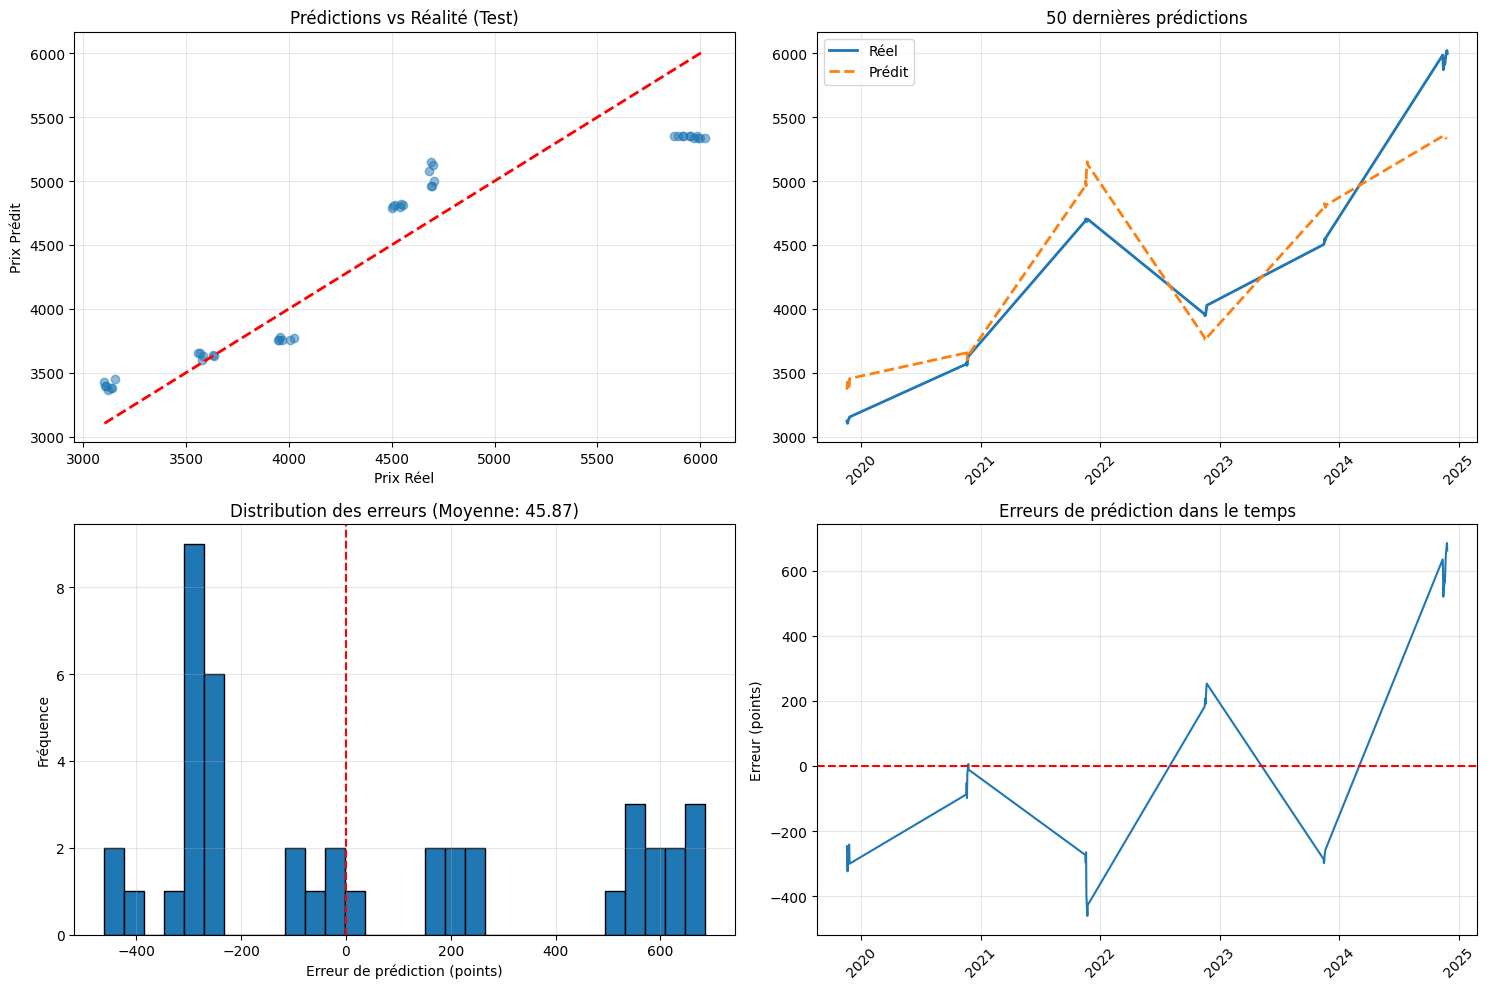

 TOP 15 FEATURES LES PLUS IMPORTANTES
ma_5_lag_1                     0.0644
price_lag_10                   0.0621
price_lag_3                    0.0592
ma_20                          0.0508
price_lag_2_lag_1              0.0456
low                            0.0446
price_lag_1_lag_1              0.0433
price_lag_2                    0.0403
MOV_AVG_50D                    0.0395
price_lag_5_lag_1              0.0392
price_lag_1                    0.0385
MOV_AVG_50D_lag_1              0.0367
price_lag_5                    0.0356
ma_50                          0.0336
price_lag_3_lag_1              0.0325


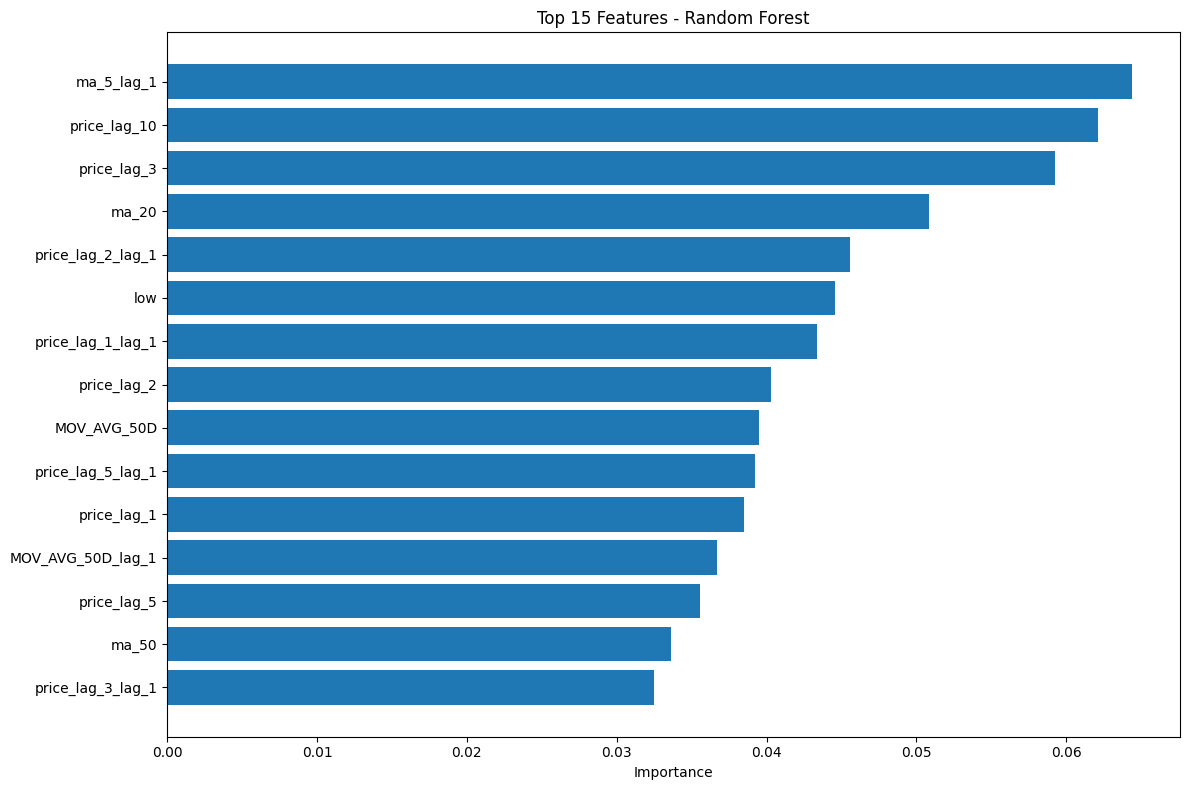

 PRÉDICTIONS DU PRIX FUTUR
2024-11-13: Prédit=5351.07, Réel=5949.17, Erreur=-598.10
2024-11-14: Prédit=5351.07, Réel=5870.62, Erreur=-519.55
2024-11-15: Prédit=5351.07, Réel=5893.62, Erreur=-542.55
2024-11-18: Prédit=5351.07, Réel=5916.98, Erreur=-565.91
2024-11-19: Prédit=5351.07, Réel=5917.11, Erreur=-566.04
2024-11-20: Prédit=5350.08, Réel=5948.71, Erreur=-598.63
2024-11-21: Prédit=5336.92, Réel=5969.34, Erreur=-632.42
2024-11-22: Prédit=5336.92, Réel=5987.37, Erreur=-650.45
2024-11-25: Prédit=5336.92, Réel=6021.63, Erreur=-684.71
2024-11-26: Prédit=5336.92, Réel=5998.74, Erreur=-661.82

💡 PRÉDICTION LA PLUS RÉCENTE: 5336.92 $


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class SP500RandomForestRegressor:
    """
    Random Forest pour prédire le PRIX FUTUR du S&P 500
    """
    
    def __init__(self):
        self.model = None
        self.data = None
        self.X = None
        self.y = None
        self.feature_names = []
        self.is_fitted = False
        
    def load_and_prepare_data(self, file_path, target_column='close', forecast_horizon=1):
        """
        Charge et prépare les données pour prédire le prix futur
        
        Parameters:
        -----------
        file_path : str
            Chemin vers le fichier Excel
        target_column : str
            Colonne contenant les prix du S&P 500
        forecast_horizon : int
            Nombre de jours à l'avance à prédire (1 = demain, 5 = dans 5 jours)
        """
        # Charger les données
        df = pd.read_excel(file_path)
        
        # Gérer l'index temporel
        date_cols = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
        if date_cols:
            df[date_cols[0]] = pd.to_datetime(df[date_cols[0]])
            df.set_index(date_cols[0], inplace=True)
            df = df.sort_index()
        
        self.data = df.copy()
        
        # Créer les features
        df = self._create_temporal_features(df, target_column)
        
        # IMPORTANT : Créer la variable cible = PRIX FUTUR
        df['target'] = df[target_column].shift(-forecast_horizon)
        
        print(f"Target créée: Prix dans {forecast_horizon} jour(s)")
        
        # Sélectionner les features (exclure le prix actuel pour éviter le data leakage)
        exclude_cols = [target_column, 'target', 'Open', 'High', 'Low', 'close']
        feature_cols = [col for col in df.columns 
                       if col not in exclude_cols 
                       and df[col].dtype in ['int64', 'float64', 'bool']]
        
        # Supprimer les lignes avec NaN
        df_clean = df[feature_cols + ['target']].dropna()
        
        self.X = df_clean[feature_cols]
        self.y = df_clean['target']
        self.feature_names = feature_cols
        
        return self.X, self.y
    
    def _create_temporal_features(self, df, target_column):
        """
        Crée des features à partir de l'historique des prix
        """
        # 1. Lags de prix (valeurs passées)
        for lag in [1, 2, 3, 5, 10]:
            df[f'price_lag_{lag}'] = df[target_column].shift(lag)
        
        # 2. Rendements passés
        df['return_1d'] = df[target_column].pct_change()
        df['return_2d'] = df[target_column].pct_change(2)
        df['return_5d'] = df[target_column].pct_change(5)
        df['return_10d'] = df[target_column].pct_change(10)
        
        # 3. Moyennes mobiles
        for window in [5, 10, 20, 50]:
            df[f'ma_{window}'] = df[target_column].rolling(window).mean()
            df[f'price_vs_ma_{window}'] = (df[target_column] - df[f'ma_{window}']) / df[f'ma_{window}']
        
        # 4. Volatilité
        df['volatility_5d'] = df['return_1d'].rolling(5).std()
        df['volatility_10d'] = df['return_1d'].rolling(10).std()
        df['volatility_20d'] = df['return_1d'].rolling(20).std()
        
        # 5. Momentum
        df['momentum_5d'] = df[target_column] / df[target_column].shift(5) - 1
        df['momentum_10d'] = df[target_column] / df[target_column].shift(10) - 1
        
        # 6. RSI (Relative Strength Index)
        delta = df[target_column].diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))
        
        # 7. Features OHLC (si disponibles)
        if all(col in df.columns for col in ['Open', 'High', 'Low', 'close']):
            df['daily_range'] = (df['High'] - df['Low']) / df['close']
            df['body'] = (df['close'] - df['Open']) / df['close']
            df['upper_shadow'] = (df['High'] - df[['Open', 'close']].max(axis=1)) / df['close']
            df['lower_shadow'] = (df[['Open', 'close']].min(axis=1) - df['Low']) / df['close']
        
        # 8. Volume (si disponible)
        if 'Volume' in df.columns:
            df['volume_ma_20'] = df['Volume'].rolling(20).mean()
            df['volume_ratio'] = df['Volume'] / df['volume_ma_20']
        
        # 10. VIX ou autres variables (si disponibles)
        for col in df.columns:
            if col not in [target_column, 'Open', 'High', 'Low', 'close', 'Volume']:
                if df[col].dtype in ['float64', 'int64']:
                    df[f'{col}_lag_1'] = df[col].shift(1)
                    df[f'{col}_change'] = df[col].diff()
        
        return df
    
    def fit_random_forest(self, n_estimators=100, max_depth=15, min_samples_split=20):
        """
        Entraîne le modèle Random Forest
        """
        if self.X is None or self.y is None:
            raise ValueError("Données non préparées. Utilisez load_and_prepare_data() d'abord.")
        
        print(f"\n🌲 Entraînement Random Forest Regressor...")
        print(f"  - Nombre d'arbres: {n_estimators}")
        print(f"  - Profondeur max: {max_depth}")
        print(f"  - Min samples split: {min_samples_split}")
        
        self.model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=10,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1,
            verbose=0
        )
        
        self.model.fit(self.X, self.y)
        self.is_fitted = True
        
        print(f"Modèle entraîné avec succès!")
        
        return self.model
    
    def optimize_hyperparameters(self):
        """
        Optimise les hyperparamètres avec validation croisée temporelle
        """
        print("\n🔍 Optimisation des hyperparamètres (cela peut prendre du temps)...")
        
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 15, 20, None],
            'min_samples_split': [20, 50, 100],
            'min_samples_leaf': [10, 20],
            'max_features': ['sqrt', 0.3, 0.5]
        }
        
        # Validation croisée temporelle (important pour séries temporelles)
        tscv = TimeSeriesSplit(n_splits=5)
        
        grid_search = GridSearchCV(
            RandomForestRegressor(random_state=42, n_jobs=-1),
            param_grid,
            cv=tscv,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(self.X, self.y)
        
        self.model = grid_search.best_estimator_
        self.is_fitted = True
        
        print(f"Meilleurs paramètres: {grid_search.best_params_}")
        print(f"Meilleur score MSE: {-grid_search.best_score_:.2f}")
        
        return self.model
    
    def validate_model(self, test_size=0.2):
        """
        Valide le modèle avec un split temporel
        """
        if not self.is_fitted:
            raise ValueError("Modèle non entraîné.")
        
        # Split temporel : les dernières données pour le test
        split_idx = int(len(self.X) * (1 - test_size))
        
        X_train, X_test = self.X.iloc[:split_idx], self.X.iloc[split_idx:]
        y_train, y_test = self.y.iloc[:split_idx], self.y.iloc[split_idx:]
        
        # Prédictions
        y_pred_train = self.model.predict(X_train)
        y_pred_test = self.model.predict(X_test)
        
        # Métriques
        print(f"VALIDATION DU MODÈLE")
        print(f"{'='*50}")
        
        print(f"DONNÉES D'ENTRAÎNEMENT ({len(X_train)} obs)")
        train_mae = mean_absolute_error(y_train, y_pred_train)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        train_r2 = r2_score(y_train, y_pred_train)
        print(f"  MAE:  {train_mae:.2f} points")
        print(f"  RMSE: {train_rmse:.2f} points")
        print(f"  R²:   {train_r2:.4f}")
        
        print(f"DONNÉES DE TEST ({len(X_test)} obs)")
        test_mae = mean_absolute_error(y_test, y_pred_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        test_r2 = r2_score(y_test, y_pred_test)
        test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
        
        print(f"  MAE:  {test_mae:.2f} points")
        print(f"  RMSE: {test_rmse:.2f} points")
        print(f"  R²:   {test_r2:.4f}")
        print(f"  MAPE: {test_mape:.2f}%")
        
        # Graphiques
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. Prédictions vs Réel (scatter)
        axes[0, 0].scatter(y_test, y_pred_test, alpha=0.5)
        axes[0, 0].plot([y_test.min(), y_test.max()], 
                       [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[0, 0].set_xlabel('Prix Réel')
        axes[0, 0].set_ylabel('Prix Prédit')
        axes[0, 0].set_title('Prédictions vs Réalité (Test)')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Série temporelle des prédictions
        recent_test = y_test.tail(50)
        recent_pred = pd.Series(y_pred_test, index=y_test.index).tail(50)
        axes[0, 1].plot(recent_test.index, recent_test, label='Réel', linewidth=2)
        axes[0, 1].plot(recent_pred.index, recent_pred, label='Prédit', 
                       linestyle='--', linewidth=2)
        axes[0, 1].set_title('50 dernières prédictions')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # 3. Erreurs de prédiction
        errors = y_test - y_pred_test
        axes[1, 0].hist(errors, bins=30, edgecolor='black')
        axes[1, 0].set_xlabel('Erreur de prédiction (points)')
        axes[1, 0].set_ylabel('Fréquence')
        axes[1, 0].set_title(f'Distribution des erreurs (Moyenne: {errors.mean():.2f})')
        axes[1, 0].axvline(x=0, color='red', linestyle='--')
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Erreurs dans le temps
        axes[1, 1].plot(y_test.index, errors)
        axes[1, 1].axhline(y=0, color='red', linestyle='--')
        axes[1, 1].set_title('Erreurs de prédiction dans le temps')
        axes[1, 1].set_ylabel('Erreur (points)')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        return {
            'train_mae': train_mae, 'train_rmse': train_rmse, 'train_r2': train_r2,
            'test_mae': test_mae, 'test_rmse': test_rmse, 'test_r2': test_r2, 'test_mape': test_mape
        }
    
    def feature_importance(self, top_n=15):
        """
        Analyse l'importance des features
        """
        if not self.is_fitted:
            raise ValueError("Modèle non entraîné.")
        
        importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(f" TOP {top_n} FEATURES LES PLUS IMPORTANTES")
        print("="*50)
        for i, row in importance_df.head(top_n).iterrows():
            print(f"{row['feature']:30s} {row['importance']:.4f}")
        
        # Graphique
        top_features = importance_df.head(top_n)
        plt.figure(figsize=(12, 8))
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Importance')
        plt.title(f'Top {top_n} Features - Random Forest')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        return importance_df
    
    def predict_future_price(self, display_last_n=10):
        """
        Prédit le prix futur avec les dernières données disponibles
        """
        if not self.is_fitted:
            raise ValueError("Modèle non entraîné.")
        
        # Utiliser les dernières observations
        last_features = self.X.iloc[-display_last_n:]
        predictions = self.model.predict(last_features)
        
        print(f" PRÉDICTIONS DU PRIX FUTUR")
        print("="*60)
        
        for i in range(len(last_features)):
            idx = last_features.index[i]
            pred_price = predictions[i]
            actual_price = self.y.loc[idx] if idx in self.y.index else None
            
            if actual_price is not None:
                error = pred_price - actual_price
                print(f"{idx.strftime('%Y-%m-%d') if hasattr(idx, 'strftime') else idx}: "
                      f"Prédit={pred_price:.2f}, Réel={actual_price:.2f}, "
                      f"Erreur={error:+.2f}")
            else:
                print(f"{idx.strftime('%Y-%m-%d') if hasattr(idx, 'strftime') else idx}: "
                      f"Prix prédit = {pred_price:.2f}")
        
        # Dernière prédiction (la plus récente)
        latest_prediction = predictions[-1]
        print(f"\n💡 PRÉDICTION LA PLUS RÉCENTE: {latest_prediction:.2f} $")
        
        return predictions

# ============================================
# EXEMPLE D'UTILISATION
# ============================================

if __name__ == "__main__":
    
    print("="*60)
    print("  RANDOM FOREST - PRÉDICTION DU PRIX S&P 500")
    print("="*60)
    
    # Créer le modèle
    rf_model = SP500RandomForestRegressor()
    
    # Charger et préparer vos données
    X, y = rf_model.load_and_prepare_data(
        "sp.xlsx",  # ← VOTRE FICHIER
        target_column='close',  # ← Ajuster selon votre colonne
        forecast_horizon=1  # Prédire le prix de demain
    )
    
    # Entraîner le modèle
    rf_model.fit_random_forest(n_estimators=100, max_depth=15)
    
    # OU optimiser les hyperparamètres (plus lent mais meilleur)
    # rf_model.optimize_hyperparameters()
    
    # Valider le modèle
    metrics = rf_model.validate_model(test_size=0.2)
    
    # Analyser l'importance des features
    importance = rf_model.feature_importance(top_n=15)
    
    # Faire des prédictions sur les dernières données
    predictions = rf_model.predict_future_price(display_last_n=10)